# TensorFlow

### Bibliotecas básicas

In [21]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [22]:
import tensorflow as tf
print(tf.__version__)

2.1.0


### Criação e execução de um grafo

In [23]:
tf.compat.v1.disable_eager_execution()

x = tf.constant(3)
y = tf.constant(4)
f = x*x*y + y + 2

with tf.compat.v1.Session() as sess:
    print(sess.run(f))

42


### Gerenciando grafos

In [24]:
x1 = tf.Variable(1)
x1.graph is tf.compat.v1.get_default_graph()

True

In [25]:
graph = tf.compat.v1.Graph()
with graph.as_default():
    x2 = tf.Variable(2)
    
x2.graph is graph

True

In [26]:
x2.graph is tf.compat.v1.get_default_graph()

False

### Ciclo de vida de um valor do nó

In [27]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.compat.v1.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)
    print(z_val)

10
15


### Regressão Linear com TensorFlow

#### Usando o Método dos mínimos quadrados

In [28]:
from sklearn.datasets import fetch_california_housing

tf.compat.v1.reset_default_graph()

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name='X')
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.compat.v1.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.compat.v1.Session() as sess:
    theta_value = theta.eval()

In [29]:
theta_value

array([[-3.6894890e+01],
       [ 4.3661433e-01],
       [ 9.4453208e-03],
       [-1.0704148e-01],
       [ 6.4345831e-01],
       [-3.9632569e-06],
       [-3.7880042e-03],
       [-4.2093179e-01],
       [-4.3400639e-01]], dtype=float32)

#### Usando Gradiente Descente em lote

**Computando os gradientes manualmente**

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

print(scaled_housing_data_plus_bias.mean())
print(scaled_housing_data_plus_bias.shape)

0.11111111111111005
(20640, 9)


In [31]:
tf.compat.v1.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name='X')
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
theta = tf.Variable(tf.compat.v1.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.compat.v1.assign(theta, theta - learning_rate * gradients)

init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print('Epoch', epoch, 'MSE =', mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

Epoch 0 MSE = 2.754427
Epoch 100 MSE = 0.63222194
Epoch 200 MSE = 0.5727803
Epoch 300 MSE = 0.5585008
Epoch 400 MSE = 0.54907006
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.5373791
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.53124255
Epoch 900 MSE = 0.5293705


In [32]:
best_theta

array([[ 2.06855226e+00],
       [ 7.74078071e-01],
       [ 1.31192386e-01],
       [-1.17845066e-01],
       [ 1.64778143e-01],
       [ 7.44081801e-04],
       [-3.91945131e-02],
       [-8.61356556e-01],
       [-8.23479712e-01]], dtype=float32)

**Usando autodiff**

In [33]:
tf.compat.v1.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name='X')
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
theta = tf.Variable(tf.compat.v1.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')

gradients = tf.compat.v1.gradients(mse, [theta])[0]

training_op = tf.compat.v1.assign(theta, theta - learning_rate * gradients)
init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print('Epoch', epoch, 'MSE =', mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

Epoch 0 MSE = 2.754427
Epoch 100 MSE = 0.63222194
Epoch 200 MSE = 0.5727803
Epoch 300 MSE = 0.5585009
Epoch 400 MSE = 0.54907006
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.5373791
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.53124255
Epoch 900 MSE = 0.5293704


In [34]:
best_theta

array([[ 2.06855249e+00],
       [ 7.74078071e-01],
       [ 1.31192386e-01],
       [-1.17845066e-01],
       [ 1.64778143e-01],
       [ 7.44078017e-04],
       [-3.91945094e-02],
       [-8.61356676e-01],
       [-8.23479772e-01]], dtype=float32)

#### Utilizando um otimizador

In [35]:
tf.compat.v1.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name='X')
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
theta = tf.Variable(tf.compat.v1.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')

optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print('Epoch', epoch, 'MSE =', mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

Epoch 0 MSE = 2.754427
Epoch 100 MSE = 0.63222194
Epoch 200 MSE = 0.5727803
Epoch 300 MSE = 0.5585009
Epoch 400 MSE = 0.54907006
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.5373791
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.53124255
Epoch 900 MSE = 0.5293704


In [36]:
best_theta

array([[ 2.06855249e+00],
       [ 7.74078071e-01],
       [ 1.31192386e-01],
       [-1.17845066e-01],
       [ 1.64778143e-01],
       [ 7.44078017e-04],
       [-3.91945094e-02],
       [-8.61356676e-01],
       [-8.23479772e-01]], dtype=float32)

### Fornecendo dados ao algoritmo de treino

In [37]:
tf.compat.v1.reset_default_graph()

A = tf.compat.v1.placeholder(tf.float32, shape=(None, 3))
B = A + 5
with tf.compat.v1.Session() as sess:
    B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [7, 8, 9]]})

print('B_val_1: ', B_val_1)
print('B_val_2:\n', B_val_2)

B_val_1:  [[6. 7. 8.]]
B_val_2:
 [[ 9. 10. 11.]
 [12. 13. 14.]]


### Gradiente descendente em minilotes

In [38]:
tf.compat.v1.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.compat.v1.placeholder(tf.float32, shape=(None, n + 1), name='X')
y = tf.compat.v1.placeholder(tf.float32, shape=(None, 1), name='y')

theta = tf.Variable(tf.compat.v1.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.compat.v1.global_variables_initializer()

In [39]:
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = scaled_housing_data_plus_bias[indices]
    y_batch = housing.target.reshape(-1, 1)[indices]
    return X_batch, y_batch

with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    best_theta = theta.eval()

In [40]:
best_theta

array([[ 2.0714476 ],
       [ 0.8462012 ],
       [ 0.11558535],
       [-0.26835832],
       [ 0.32982782],
       [ 0.00608358],
       [ 0.07052915],
       [-0.87988573],
       [-0.8634251 ]], dtype=float32)

### Salvar e restaurar um modelo

#### Salvando

In [42]:
n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name='X')
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
theta = tf.Variable(tf.compat.v1.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print('Epoch', epoch, 'MSE =', mse.eval())
            save_path = saver.save(sess, '/tmp/my_model.ckpt')
        sess.run(training_op)
    
    best_theta = theta.eval()
    save_path = saver.save(sess, '/tmp/my_model_final.ckpt')

Epoch 0 MSE = 2.754427
Epoch 100 MSE = 0.63222194
Epoch 200 MSE = 0.5727803
Epoch 300 MSE = 0.5585009
Epoch 400 MSE = 0.54907006
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.5373791
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.53124255
Epoch 900 MSE = 0.5293704


#### Restaurando

In [44]:
with tf.compat.v1.Session() as sess:
    saver.restore(sess, '/tmp/my_model_final.ckpt')
    best_theta_restored = theta.eval()

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


#### Salvando uma variável específica

In [46]:
saver = tf.compat.v1.train.Saver({'weight': theta})

#### Restaurando a estrutura do grafo

In [48]:
tf.compat.v1.reset_default_graph()

saver = tf.compat.v1.train.import_meta_graph('/tmp/my_model_final.ckpt.meta')
theta = tf.compat.v1.get_default_graph().get_tensor_by_name('theta:0')

with tf.compat.v1.Session() as sess:
    saver.restore(sess, '/tmp/my_model_final.ckpt')
    best_theta_restored = theta.eval()

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


### TensorBoard

In [50]:
%load_ext tensorboard

In [51]:
from datetime import datetime

tf.compat.v1.reset_default_graph()

now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
root_logdir = 'tf_logs'
logdir = '{}/run-{}/'.format(root_logdir, now)

In [56]:
n_epochs = 1000
learning_rate = 0.01
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

X = tf.compat.v1.placeholder(tf.float32, shape=(None, n + 1), name='X')
y = tf.compat.v1.placeholder(tf.float32, shape=(None, 1), name='y')
theta = tf.Variable(tf.compat.v1.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.compat.v1.global_variables_initializer()

mse_summary = tf.compat.v1.summary.scalar('MSE', mse)
file_writer = tf.compat.v1.summary.FileWriter(logdir, tf.compat.v1.get_default_graph())

with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval() 
    
file_writer.flush()
file_writer.close()

In [57]:
tensorboard --logdir tf_logs/

Reusing TensorBoard on port 6006 (pid 14500), started 1:47:55 ago. (Use '!kill 14500' to kill it.)

### Escopo do nome

In [60]:
X = tf.compat.v1.placeholder(tf.float32, shape=(None, n + 1), name='X')
y = tf.compat.v1.placeholder(tf.float32, shape=(None, 1), name='y')
theta = tf.Variable(tf.compat.v1.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name='theta')
y_pred = tf.matmul(X, theta, name='predictions')

with tf.name_scope('loss') as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name='mse')
    
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.compat.v1.global_variables_initializer()

mse_summary = tf.compat.v1.summary.scalar('MSE', mse)
file_writer = tf.compat.v1.summary.FileWriter(logdir, tf.compat.v1.get_default_graph())

with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval() 
    
file_writer.flush()
file_writer.close()

In [61]:
tensorboard --logdir tf_logs/

Reusing TensorBoard on port 6006 (pid 14500), started 1:52:08 ago. (Use '!kill 14500' to kill it.)

### Modularização

In [69]:
tf.compat.v1.reset_default_graph()

def relu(X):
    with tf.name_scope('relu'):
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.compat.v1.random_normal(w_shape), name='weights')
        b = tf.Variable(0.0, name='bias')
        z = tf.add(tf.matmul(X, w), b, name='z')
        return tf.maximum(z, 0., name='max')
    

n_features = 3
X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_features), name='X')
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name='output')

file_writer = tf.compat.v1.summary.FileWriter('logs/relu2', tf.compat.v1.get_default_graph())
file_writer.flush()
file_writer.close()

In [70]:
tensorboard --logdir logs/

Reusing TensorBoard on port 6007 (pid 15683), started 1:23:07 ago. (Use '!kill 15683' to kill it.)

### Compartilhando variáveis

In [72]:
tf.compat.v1.reset_default_graph()

def relu(X):
    threshold = tf.compat.v1.get_variable('threshold', shape=(), initializer=tf.constant_initializer(0.0))
    w_shape = (int(X.get_shape()[1]), 1)
    w = tf.Variable(tf.compat.v1.random_normal(w_shape), name='weights')
    b = tf.Variable(0.0, name='bias')
    z = tf.add(tf.matmul(X, w), b, name='z')
    return tf.maximum(z, threshold, name='max')

X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_features), name='X')
relus = []

for relu_index in range(5):
    with tf.compat.v1.variable_scope('relu', reuse=(relu_index >= 1)) as scope:
        relus.append(relu(X))
output = tf.add_n(relus, name='output')

file_writer = tf.compat.v1.summary.FileWriter("logs/relu3", tf.compat.v1.get_default_graph())
file_writer.flush()
file_writer.close()

In [73]:
tensorboard --logdir logs/relu3

### Exercício do capítulo

*12*

Exercício:  Regressão logística com gradiente descendente em minibatch usando TensorFlow

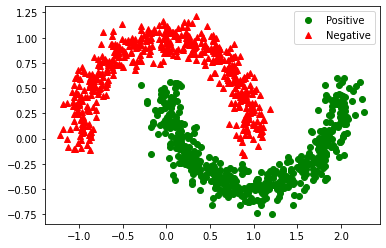

In [74]:
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)
y_moons_column_vector = y_moons.reshape(-1, 1)


plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

In [75]:
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]
X_moons_with_bias[:5]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665]])

In [76]:
test_ratio = 0.2
test_size = int(m * test_ratio)

X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

In [77]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

In [81]:
tf.compat.v1.reset_default_graph()

n_inputs = 2
learning_rate = 0.01
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))


X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs + 1), name='X')
y = tf.compat.v1.placeholder(tf.float32, shape=(None, 1), name='y')
theta = tf.Variable(tf.compat.v1.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42), name='theta')
logits = tf.matmul(X, theta, name='logits')
y_proba = tf.compat.v1.sigmoid(logits)
loss = tf.compat.v1.losses.log_loss(y, y_proba)

optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print('Epoch:', epoch, '\tLoss:', loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 0.8754736
Epoch: 100 	Loss: 0.35254875
Epoch: 200 	Loss: 0.3109098
Epoch: 300 	Loss: 0.2945486
Epoch: 400 	Loss: 0.2857174
Epoch: 500 	Loss: 0.28113994
Epoch: 600 	Loss: 0.2788698
Epoch: 700 	Loss: 0.27679923
Epoch: 800 	Loss: 0.27570274
Epoch: 900 	Loss: 0.27458203


In [82]:
from sklearn.metrics import precision_score, recall_score

y_pred = (y_proba_val >= 0.5)
y_pred[:5]

print(f'Precisão: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')

Precisão: 0.8627450980392157
Recall: 0.8888888888888888


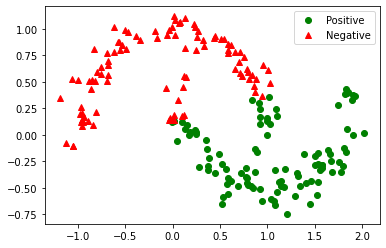

In [83]:
y_pred_idx = y_pred.reshape(-1)
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label='Positive')
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label='Negative')
plt.legend()
plt.show()